In [ ]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
torchvision.__version__  # should be 0.2.1
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
pip install split_folders

# Import data from kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Autorisation 
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Colab Notebooks/Data use"

In [ ]:
! kaggle datasets download phylake1337/fire-dataset

 98% 379M/387M [00:02<00:00, 160MB/s]
100% 387M/387M [00:02<00:00, 153MB/s]


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

In [ ]:
#data path
input_path="/content/fire_dataset"

In [ ]:
import splitfolders
splitfolders.ratio('/content/fire_dataset', output="fire_dataset", seed=1337, ratio=(.8, 0.2))

# Data augmentation and normalisation

In [ ]:
# data augmentation
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((160,160)), # size of the input in the googlenet architecture 
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # data normalisation
    ]),
    'val':
    transforms.Compose([
        transforms.Resize((160,160)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
    ]),
}
#data_transform
image_datasets = {
    'train': 
    datasets.ImageFolder(input_path + '/train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(input_path + '/val', data_transforms['val'])
}
# loading data
dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),  # for Kaggle
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)  # for Kaggle
}

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Importing the googlenet pretrained model

In [ ]:
model_conv = torchvision.models.googlenet(pretrained=True)
use_cuda = torch.cuda.is_available()
if use_cuda:
    model_transfer = model_conv.cuda()
for param in model_conv.parameters():
    param.requires_grad = False # we need to freeze all the network except the final layer. 
                                # We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [ ]:
# Add the last fully connected layer
n_inputs = model_conv.fc.in_features
print(n_inputs)
last_layer = nn.Linear(n_inputs,2)  
model_conv.fc = last_layer  # Add last linear layer
if use_cuda:
    model_conv = model_conv.cuda()

1024


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_conv.parameters(), lr=0.001,momentum=0.9)

# Training

In [ ]:
# training the model
def train_model(model, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [ ]:
model_trained = train_model(model_conv, criterion, optimizer, num_epochs=10)

Epoch 1/10
----------
train loss: 0.4102, acc: 0.7960
validation loss: 0.3573, acc: 0.8650
Epoch 2/10
----------
train loss: 0.3377, acc: 0.8761
validation loss: 0.3080, acc: 0.8700
Epoch 3/10
----------
train loss: 0.2936, acc: 0.8911
validation loss: 0.2798, acc: 0.8850
Epoch 4/10
----------
train loss: 0.2714, acc: 0.9086
validation loss: 0.2610, acc: 0.9050
Epoch 5/10
----------
train loss: 0.2629, acc: 0.9049
validation loss: 0.2420, acc: 0.9050
Epoch 6/10
----------
train loss: 0.2355, acc: 0.9149
validation loss: 0.2422, acc: 0.9250
Epoch 7/10
----------
train loss: 0.2281, acc: 0.9212
validation loss: 0.2232, acc: 0.8900
Epoch 8/10
----------
train loss: 0.2144, acc: 0.9262
validation loss: 0.2153, acc: 0.9300
Epoch 9/10
----------
train loss: 0.2126, acc: 0.9237
validation loss: 0.2201, acc: 0.9200
Epoch 10/10
----------
train loss: 0.1927, acc: 0.9587
validation loss: 0.2047, acc: 0.9300


In [ ]:
class_names = image_datasets['train'].classes /content/fire_dataset/val/fire_images/fire.114.png
print(class_names)

['fire_images', 'non_fire_images']


# Prediction

In [ ]:
# specify images for prediction
validation_img_paths = ["/val/non_fire_images/non_fire.123.png",
                        "/val/non_fire_images/non_fire.126.png",
                        "/val/fire_images/fire.114.png"]
img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]

In [ ]:
# image normalisation and augmentation 
validation_batch = torch.stack([data_transforms['val'](img).to(device) for img in img_list])
pred_logits_tensor = model_conv(validation_batch)
# prediction result
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[0.12570767, 0.8742924 ],
       [0.12605569, 0.87394434],
       [0.9336319 , 0.06636808]], dtype=float32)

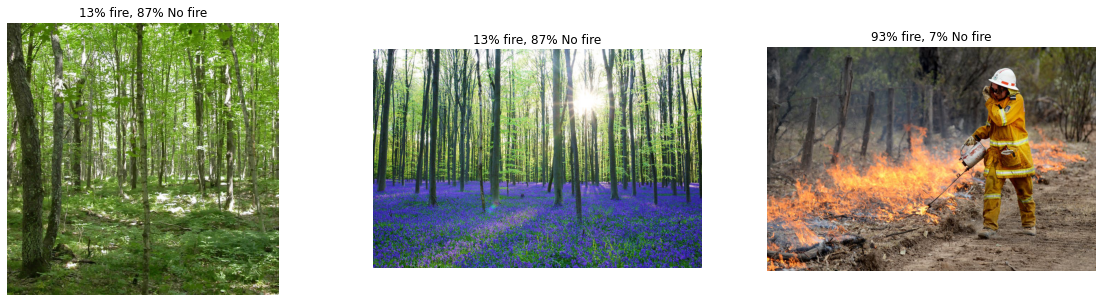

In [ ]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% fire, {:.0f}% No fire" .format(100*pred_probs[i,0], 100*pred_probs[i,1]))
    ax.imshow(img)